In [1]:
import nltk
nltk.download('nps_chat')

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Unzipping corpora/nps_chat.zip.


True

In [2]:
from nltk.corpus import nps_chat
from sklearn.model_selection import train_test_split
from tensorflow import keras as k
import numpy as np
import re

In [3]:
nps_chat.tagged_posts()

[[('now', 'RB'), ('im', 'PRP'), ('left', 'VBD'), ('with', 'IN'), ('this', 'DT'), ('gay', 'JJ'), ('name', 'NN')], [(':P', 'UH')], ...]

In [4]:
def filters(punc=True):
    def inner_filters(x):
        punctuation = r"\^\.|[\.|\`|:|,|\)|\(|\"|\']+"
        condition = [x[0].strip() , x[1].strip()]
        if punc:
            condition.append(not(re.match(punctuation, x[0].strip())))
            condition.append(not(re.match(punctuation, x[1].strip())))
        return  all(condition)

    return inner_filters
    
data = [list(filter(filters , sentence)) for sentence in nps_chat.tagged_posts()]

In [ ]:
sum(map(len,nps_chat.tagged_posts())) - sum(map(len,data))

2

In [5]:
def word_to_int(data,set_of_words,index_shift=1,padding=True):
    mapper = dict(map(lambda x: x[::-1], enumerate(set_of_words))) # map each word to it's indices
    # map each word to an integer, 1 for OOV (out of vocab)
    word2int = lambda vec: [mapper[word]+ index_shift if word in mapper.keys() else 1 for word in vec]
    mapped_data = list(map(word2int, data))
    if padding:
        mapped_data=k.preprocessing.sequence.pad_sequences(mapped_data, padding= 'post') # pad sentences with 0
    return mapped_data

In [6]:
vocab = [w.lower() for w in nps_chat.words()]
vocab = list(set(vocab)) # create set of words
train_data = [[tup[0].lower() for tup in sentence] for sentence in data] # extract training data from corpus

n= int(len(train_data)/10)
test_data = train_data[:n]
train_data = train_data[n:]

train_data = np.array(word_to_int(train_data,vocab,index_shift=2,padding=True))
test_data = word_to_int(test_data,vocab,index_shift=2,padding=False) # no padding for test data

print("train_data",train_data.shape)
print("test_data",len(test_data))

train_data (9511, 87)
test_data 1056


In [7]:
label = [[tup[1] for tup in sentence] for sentence in data] # extract training label from corpus

# Let's see what we have in tags:
tag_set = set(sum(label,[]))
print("number of tags in data:",len(tag_set))
print(" - ".join(tag_set))

# remove "^" character
label = [[word.replace("^","") for word in sentence] for sentence in label]

# replace all punctuation with one label
label = [[re.sub(r"[\.|\`|:|,|\)|\(|\"|\']+","Punctuation",word) for word in sentence] for sentence in label]

tag_set = list(set(sum(label,[])))
print("\nnumber of tags in data after preprocessing:",len(tag_set))
print(" - ".join(tag_set),"\n")

test_label = label[:n]
train_label = label[n:]

train_label = np.array(word_to_int(train_label,tag_set,index_shift=1,padding=True))
test_label = word_to_int(test_label,tag_set,index_shift=1,padding=False)

print("train_label",train_label.shape)
print("test_label",len(test_label))

number of tags in data: 74
 - WRB - DT - NN - PRP$ - `` - NNS - ^VBD - ^NNS - VB - , - JJ - ^WRB - UH - VBG - . - ^NNP - RBR - PRP - RP - ^JJR - CC - WP - ^NN - VBP - ^DT - ^PRP - ^WP - VBD - NNP - ^POS - RBS - VBN - LS - ^VBZ - VBZ - TO - ^VB - ^UH - MD - X - ^TO - SYM - JJS - ^JJ - ^PRP$ - GW - NNPS - HVS - WDT - ^RB - FW - ^VBN - ^JJS - JJR - PDT - : - IN - '' - ^VBP - ) - ^VBG - ^MD - BES - CD - EX - ^. - ^IN - RB - ( - POS - ^PRP^VBP - ^RP - ^CC

number of tags in data after preprocessing: 42
 - WRB - DT - NN - PRP$ - PRPVBP - NNS - VB - JJ - UH - VBG - RBR - PRP - RP - CC - WP - VBP - VBD - NNP - RBS - VBN - LS - VBZ - TO - MD - X - SYM - JJS - GW - NNPS - HVS - WDT - FW - JJR - PDT - IN - BES - CD - EX - RB - Punctuation - POS 

train_label (9511, 87)
test_label 1056


In [8]:
train_sahpe = (train_data.shape[1], )
embedding_dim = 64
rnn_cell_dim = 128

In [9]:
input = k.layers.Input(shape=train_sahpe)
embedded = k.layers.Embedding(len(vocab)+2,embedding_dim,input_length=train_sahpe[0],mask_zero=True)(input)
rnn_layer = k.layers.LSTM(rnn_cell_dim, return_sequences=True)
rnn_output = k.layers.Bidirectional(rnn_layer, merge_mode='ave')(embedded)
rnn_output = k.layers.Bidirectional(rnn_layer, merge_mode='ave')(rnn_output)
predictions = k.layers.Dense(len(tag_set)+1, activation='softmax')(rnn_output)

model = k.Model(inputs=input, outputs=predictions)

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 87)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 87, 64)            348352    
_________________________________________________________________
bidirectional (Bidirectional (None, 87, 128)           197632    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 87, 128)           263168    
_________________________________________________________________
dense (Dense)                (None, 87, 43)            5547      
Total params: 814,699
Trainable params: 814,699
Non-trainable params: 0
_________________________________________________________________
None


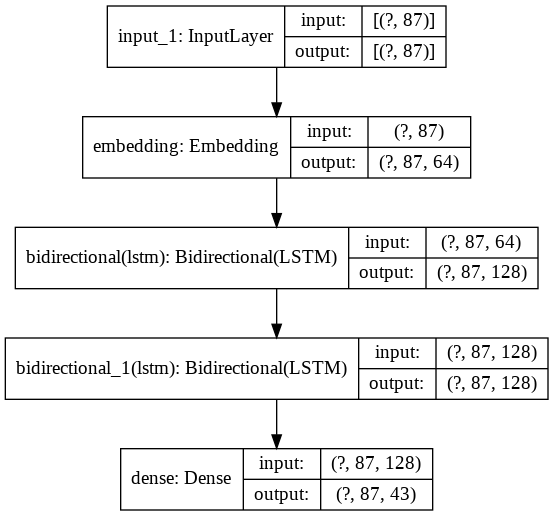

In [10]:
k.utils.plot_model(model, show_shapes=True)

In [ ]:
batch = 100
num_epochs = 20
model.compile(optimizer=k.optimizers.Adam(),
                           loss=k.losses.SparseCategoricalCrossentropy(),
                           metrics=[k.metrics.SparseCategoricalAccuracy(name='accuracy')])

model.fit(x=train_data,y=train_label, batch_size=batch, epochs=num_epochs, validation_split=0.1)

In [ ]:
eval_data = k.preprocessing.sequence.pad_sequences(test_data,padding='post')
eval_label = k.preprocessing.sequence.pad_sequences(test_label,padding='post')
model.evaluate(x=eval_data,y=eval_label)

33/33 [==============================] - 1s 35ms/step - loss: 0.0658 - accuracy: 0.8746


[0.06580081582069397, 0.874616265296936]

In [ ]:
pred=[]
for sentence in test_data:
    prediction = model.predict(np.array(sentence))
    prediction = np.argmax(prediction, axis=-1).tolist()
    prediction = prediction[:len(sentence)]
    pred.append(prediction)

In [ ]:
from sklearn import metrics

y_true, y_pred = sum(test_label,[]), sum(pred,[])

#print(metrics.confusion_matrix(y_true, y_pred)
print(metrics.classification_report(y_true,y_pred, labels=range(len(tag_set)+1), target_names=tag_set))


              precision    recall  f1-score   support

         WRB       0.00      0.00      0.00         0
         NNS       0.83      0.96      0.89        25
         PDT       0.89      0.63      0.74       111
          JJ       0.00      0.00      0.00         1
         WDT       0.83      0.36      0.50       180
         VBP       0.00      0.00      0.00         5
          MD       0.91      0.59      0.71       164
          GW       0.87      1.00      0.93        40
          IN       0.00      0.00      0.00         1
         JJS       0.91      0.91      0.91       180
         VBZ       0.50      0.50      0.50         2
         JJR       0.94      0.74      0.83       115
         HVS       1.00      0.33      0.50         6
          RP       0.00      0.00      0.00         1
          DT       0.53      0.76      0.63        21
         PRP       0.94      0.95      0.94       195
         POS       0.95      0.95      0.95       385
        PRP$       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1989: UserWarning: labels size, 42, does not match size of target_names, 41
  .format(len(labels), len(target_names))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
